Epoch 1: train loss = 0.3569
Epoch 2: train loss = 0.1337
Epoch 3: train loss = 0.1031
Epoch 4: train loss = 0.0877
Epoch 5: train loss = 0.0791
Test accuracy: 97.71%


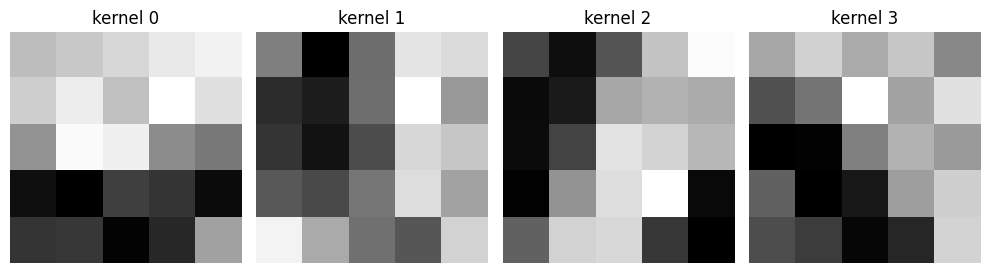

In [2]:
# simple_interpretable_cnn.py
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# 1. 하이퍼파라미터 및 데이터셋 --------------------------------------------------
BATCH_SIZE   = 128
EPOCHS       = 5         # 적은 epoch만 돌려도 kernel 패턴이 보입니다.
LR           = 1e-3
DEVICE       = 'cuda' if torch.cuda.is_available() else 'cpu'

transform = transforms.Compose([
    transforms.ToTensor(),                   # [0,1]
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST 평균·표준편차
])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='./data', train=True, download=True, transform=transform),
    batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='./data', train=False, download=True, transform=transform),
    batch_size=BATCH_SIZE, shuffle=False)

# 2. 모델 정의 ------------------------------------------------------------------
class TinyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 4, kernel_size=5, padding=2, bias=False)  # kernel 네 개
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)      # 28→14
        self.fc   = nn.Linear(4 * 14 * 14, 10)

    def forward(self, x):
        x = self.relu(self.conv(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

model = TinyCNN().to(DEVICE)

# 3. 학습 루프 -------------------------------------------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    for data, target in train_loader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss   = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * data.size(0)
    print(f'Epoch {epoch}: train loss = {running_loss / len(train_loader.dataset):.4f}')

# 4. 테스트 정확도 ---------------------------------------------------------------
model.eval()
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        output = model(data)
        pred   = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
print(f'Test accuracy: {100. * correct / len(test_loader.dataset):.2f}%')

# 5. kernel 시각화 --------------------------------------------------------------
# Conv2d weight shape: [out_channels, in_channels, H, W]
kernels = model.conv.weight.data.cpu()

fig, axes = plt.subplots(1, 4, figsize=(10, 3))
for idx, ax in enumerate(axes):
    ax.imshow(kernels[idx, 0, :, :], cmap='gray')
    ax.set_title(f'kernel {idx}')
    ax.axis('off')
plt.tight_layout()
plt.show()
